In [1]:
import os
import numpy as np
import pandas as pd
import pyreadstat
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.mixture import GaussianMixture
from joblib import Parallel, delayed
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans as SparkKMeans, GaussianMixture as SparkGMM
from pyspark.ml.feature import VectorAssembler, PCA as SparkPCA
from pyspark.mllib.linalg.distributed import RowMatrix
from pyspark.mllib.linalg import Vectors

In [2]:
# load the path
os.chdir('/Users/lijiayu/Desktop/MACS_30700_Final/')

In [3]:
print("Current Working Directory:", os.getcwd())

Current Working Directory: /Users/lijiayu/Desktop/MACS_30700_Final


In [4]:
# load relationships
edges_file = "dataset/pokec/soc-pokec-relationships.txt"
edges = pd.read_csv(edges_file, sep="\t", header=None, names=["source", "target"])

# display first few rows
print(edges.head())

   source  target
0       1      13
1       1      11
2       1       6
3       1       3
4       1       4


In [5]:
display(edges.head())

,source,target
0,1,13
1,1,11
2,1,6
3,1,3
4,1,4


In [6]:
# load user profiles
profiles_file = "dataset/pokec/soc-pokec-profiles.txt"

# read a few rows to check structure
with open(profiles_file, "r", encoding="utf-8") as file:
    sample_lines = [next(file) for _ in range(5)]

# count the number of tab-separated values in each row
for i, line in enumerate(sample_lines):
    print("line {}: {} columns".format(i+1, len(line.strip().split("\t"))))

line 1: 59 columns
line 2: 59 columns
line 3: 59 columns
line 4: 59 columns
line 5: 59 columns


In [7]:
profiles = pd.read_csv(profiles_file, sep="\t", header=None)

# display first row to inspect column structure
print(profiles.iloc[0].values)
print("total columns detected:", profiles.shape[1])

[1 1 14 1.0 'zilinsky kraj, zilina' '2012-05-25 11:20:00.0'
 '2005-04-03 00:00:00.0' 26.0 '185 cm, 90 kg' 'it' 'anglicky'
 'sportovanie, spanie, kino, jedlo, pocuvanie hudby, priatelia, divadlo'
 'v dobrej restauracii' 'mam psa' nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
total columns detected: 60


In [8]:
# display first row to inspect column structure
print(profiles.iloc[1].values)
print("total columns detected:", profiles.shape[1])

[2 1 62 0.0 'zilinsky kraj, kysucke nove mesto' '2012-05-25 23:08:00.0'
 '2007-11-30 00:00:00.0' 0.0 '166 cm, 58 kg' nan 'nemecky'
 'turistika, prace okolo domu, praca s pc, pocuvanie hudby, pozeranie filmov, tancovanie, diskoteky, kupalisko, varenie, party, priatelia, spanie, nakupovanie, stanovanie'
 'pri svieckach s partnerom' 'macka' 'priemerna' 'vyborny' 'zelene'
 'cierne' 'dlhe'
 'zakladne, ale som uz na strednej skole dufam ze ju spravim'
 'cierna, modra, ruzova' 'nefajcim'
 'pijem prilezitostne, iba ked sa nieco kona a to napr. na zabave,na chate,na stanovackach a pod.'
 'byk' 'dobreho priatela, priatelku, mozno aj viac'
 'nie je nic lepsie, ako byt zamilovany(a)' 'iba s mojou laskou'
 'laskou mojho zivota' 'slobodny(a)'
 'no budu a tak chcem 2 deti staci a tak ked budeme vladat tak bude aj viac co ja viem co ma v zivote postretne:d'
 'v buducnosti chcem mat deti' 'komedie, romanticke' 'doma z gauca'
 'disko, pop, rap a jasn eto co teraz leti najviac nejlepsie je fun-radio'
 'n

In [9]:
# display first row to inspect column structure
print(profiles.iloc[2].values)
print("total columns detected:", profiles.shape[1])

[16 1 64 1.0 'zilinsky kraj, kysucke nove mesto' '2012-05-25 23:19:40.0'
 '2008-05-18 00:00:00.0' 23.0 '173 cm, 70 kg'
 'najvatcsej firme na svete urad prace'
 'no predsa svoj :d a najlepsie druhy'
 'cestovanie, pocuvanie hudby, nenudit sa' 'v dobrej restauracii'
 'ja a nas prefikany alik :)'
 'nemozem pribrat nedasa smola som moc aktivny'
 'to co by som mal nosit tak nenosim asi tak' 'hnede' 'hnede hnede' nan
 'coskoro 24.5 alebo 31.9    :d' 'biela, modra, zelena' 'nemam'
 'pijem iba ked musim ...svadby.pohreby.krstiny a tak' 'lev' nan
 'oplati sa pre nu bojovat' 'ja uz som stary na take veci :)'
 'ked ho stretnem tak vam o nom porozpravam :)' 'slobodny(a)'
 'casom ak budem este vladat :d' nan 'take co ma uputaju'
 'v kine s ludmy ktory mam rad'
 'hoci co co zapasuje ale klasa vede atb samozrejme najnovsie co sa hrava vrebrickoch hytparad :xd'
 'samozrejme sam kazdy ma iny vkus neda sa vsetkym vyhoviet' nan
 'ak sa to da ziet tak setko' nan 'nie' 'lyzovanie, plavanie' 'non kanal'
 'bi

In [10]:
# display first row to inspect column structure
print(profiles.iloc[3].values)
print("total columns detected:", profiles.shape[1])

[3 0 38 1.0 'bratislavsky kraj, bratislava - karlova ves'
 '2012-05-10 18:05:00.0' '2010-05-23 00:00:00.0' 29.0 nan
 'reklamy a medii, sluzieb a obchodu' 'anglicky, nemecky'
 'sportovanie, cestovanie' nan nan nan nan 'zelene' 'hnede' nan nan
 'cierna, modra' nan nan nan
 'dobreho priatela, priatelku, niekoho na chatovanie' nan nan nan
 'slobodny(a)' nan nan
 'akcne, horory, komedie, sci-fi, dokumentarne, historicke' nan
 'rock, metal, house, techno, pop, oldies, jazz'
 'v aute, v praci, na koncerte, s partnerom' nan
 'slovenskej, talianskej, japonskej' nan 'pravidelne'
 'hokej, futbal, auto-moto sporty, squash'
 'auto-moto sporty, futbal, hokej' nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
total columns detected: 60


In [11]:
# define the correct column indices for the selected sociodemographic attributes
selected_columns = [0, 3, 7, 19, 29, 28]  # indices based on dataset description

# extract only the required columns
profiles = profiles.iloc[:, selected_columns]

# rename the columns properly
profiles.columns = ["user_id", "gender", "age", "completed_level_of_education", "children", "marital_status"]

# display first few rows to confirm
print(profiles.head())


   user_id  gender   age                       completed_level_of_education  \
0        1     1.0  26.0                                                NaN   
1        2     0.0   0.0  zakladne, ale som uz na strednej skole dufam z...   
2       16     1.0  23.0                      coskoro 24.5 alebo 31.9    :d   
3        3     1.0  29.0                                                NaN   
4        4     0.0  26.0                                                NaN   

                                            children marital_status  
0                                                NaN            NaN  
1  no budu a tak chcem 2 deti staci a tak ked bud...    slobodny(a)  
2                      casom ak budem este vladat :d    slobodny(a)  
3                                                NaN    slobodny(a)  
4                                                NaN            NaN  


In [12]:
display(profiles.tail())

,user_id,gender,age,completed_level_of_education,children,marital_status
1632798,1632799,0.0,23.0,NaN,NaN,NaN
1632799,1632800,1.0,33.0,NaN,NaN,NaN
1632800,1632801,1.0,0.0,NaN,NaN,NaN
1632801,1632802,1.0,19.0,NaN,NaN,NaN
1632802,1632803,0.0,44.0,NaN,NaN,NaN


In [13]:
# remove rows that contain any na values in the selected columns
profiles_cleaned = profiles.dropna()

# check how many rows were removed
print(f"original dataset size: {profiles.shape[0]}")
print(f"cleaned dataset size: {profiles_cleaned.shape[0]}")
print(f"rows removed: {profiles.shape[0] - profiles_cleaned.shape[0]}")

original dataset size: 1632803
cleaned dataset size: 355005
rows removed: 1277798


In [14]:
# display first few rows after filtering
display(profiles_cleaned.head())

,user_id,gender,age,completed_level_of_education,children,marital_status
1,2,0.0,0.0,"zakladne, ale som uz na strednej skole dufam z...",no budu a tak chcem 2 deti staci a tak ked bud...,slobodny(a)
2,16,1.0,23.0,coskoro 24.5 alebo 31.9 :d,casom ak budem este vladat :d,slobodny(a)
11,32,1.0,21.0,stredoskolske...mechanik elektrotechnik....bac...,"nemam, ale zevraj v aprili cosi bude....tak tr...","mam vazny vztah,este vaznejzi ako vazny..."
17,46,0.0,21.0,"zakladne, , stredoskolske",chcem 3 deti,slobodny(a)
18,21,0.0,17.0,zakladne,hmm deti by som do buducnosti cela mat aspon 3...,slobodny(a)


In [15]:
display(profiles_cleaned["children"].unique())


array(['no budu a tak chcem 2 deti staci a tak ked budeme vladat tak bude aj viac co ja viem co ma v zivote postretne:d',
       'casom ak budem este vladat :d',
       'nemam, ale zevraj v aprili cosi bude....tak treba chodit do polska na plienky... :)',
       ..., 'zatial ziadne. dufam, ze to nie je konecny stav  :)',
       'mam 2, uz dospele', 'uz vyleteli z hniezda:)'], dtype=object)

In [16]:
display(profiles_cleaned["gender"].unique())

array([0., 1.])

In [17]:
display(profiles_cleaned["age"].unique())

array([  0.,  23.,  21.,  17.,  22.,  19.,  26.,  20.,  16.,  18.,  29.,
        24.,  27.,  30.,  25.,  15.,  28.,  13.,  14.,  12.,  37.,  32.,
        47.,  36.,  33.,  43.,  31.,  42.,  11.,   7., 111.,  10.,  38.,
        48.,  35.,  46.,  52.,  44.,  34.,  41.,  40.,  39.,  49.,  45.,
         9.,   4., 112.,  56.,   1.,   8., 102.,  96.,  77.,  53.,  50.,
        71.,  91.,   3.,  51., 110.,  80.,   2.,  55.,  57.,  90., 100.,
        67., 104.,  76.,  86.,  88.,  54.,  62.,  60.,  66.,  99., 101.,
        83.,  59.,  82.,   5.,  79.,  58.,   6.,  70.,  68.,  89.,  63.,
        92.,  98.,  97.,  64.,  61.,  81., 106.,  94., 107.,  65.,  87.,
       108.,  93.,  72., 103.,  69.,  84.,  73.,  74.,  75., 105.,  95.,
        85.,  78.])

In [18]:
display(profiles_cleaned["completed_level_of_education"].unique())

array(['zakladne, ale som uz na strednej skole dufam ze ju spravim',
       'coskoro 24.5 alebo 31.9    :d',
       'stredoskolske...mechanik elektrotechnik....bacha na mna', ...,
       's maturitov',
       'vzdelanie,no neucil som sa nikdy,vzdy zlaty stred..mam odbornu profesiu,mechanik strojov a zariadeni',
       'kompletne 3. stupen vysokoskolskeho'], dtype=object)

In [19]:
display(profiles_cleaned["marital_status"].unique())

array(['slobodny(a)', 'mam vazny vztah,este vaznejzi ako vazny...',
       'stastny...:)', ..., 'mam vazny vztah,z laskou mojho zivota',
       'rozvedeny(a), cize slobodny', 'rozvedeny(a), stastne rozvedena:)'],
      dtype=object)

In [20]:
# define valid age range
profiles_cleaned = profiles_cleaned[(profiles_cleaned["age"] >= 15) & (profiles_cleaned["age"] <= 100)]

# define Eurobarometer age bins
age_bins = [15, 18, 25, 44, 64, 100]
age_labels = ["15-18", "19-25", "26-44", "45-64", "65+"]
profiles_cleaned["age_group"] = pd.cut(profiles_cleaned["age"], bins=age_bins, labels=age_labels, right=True)

# drop rows where age_group is NaN
profiles_cleaned = profiles_cleaned.dropna(subset=["age_group"])

# drop original age column since we now have a standardized grouping
profiles_cleaned.drop(columns=["age"], inplace=True)

# check if any missing values remain
print(profiles_cleaned.isna().sum())


user_id                         0
gender                          0
completed_level_of_education    0
children                        0
marital_status                  0
age_group                       0
dtype: int64


In [21]:
# map gender values
profiles_cleaned["gender"] = profiles_cleaned["gender"].map({0.0: "Female", 1.0: "Male"})

19-25    41.689065
26-44    35.709168
15-18    17.696967
45-64     4.742841
65+       0.161959
Name: age_group, dtype: float64


/var/folders/yy/wn0z53b977q818d7g3560t400000gn/T/ipykernel_6431/1147512913.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_distribution.index, y=age_distribution.values, palette="Blues_r")


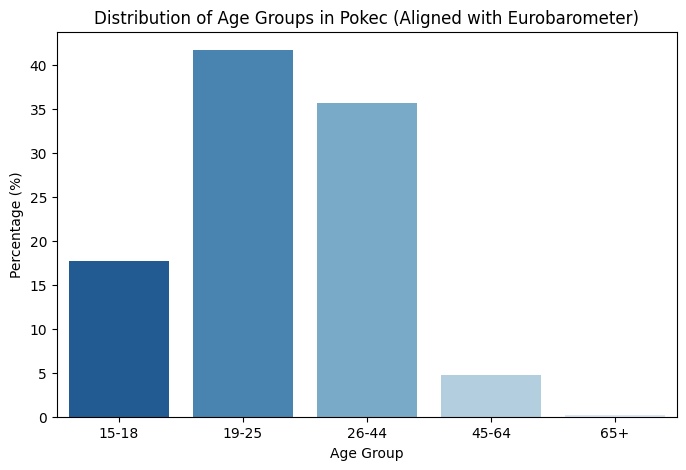

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# count distribution of age groups
age_distribution = profiles_cleaned["age_group"].value_counts(normalize=True) * 100
print(age_distribution)

# plot age distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=age_distribution.index, y=age_distribution.values, palette="Blues_r")
plt.xlabel("Age Group")
plt.ylabel("Percentage (%)")
plt.title("Distribution of Age Groups in Pokec (Aligned with Eurobarometer)")
plt.show()

Female    51.12351
Male      48.87649
Name: gender, dtype: float64


/var/folders/yy/wn0z53b977q818d7g3560t400000gn/T/ipykernel_6431/310349551.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_distribution.index, y=gender_distribution.values, palette="coolwarm")


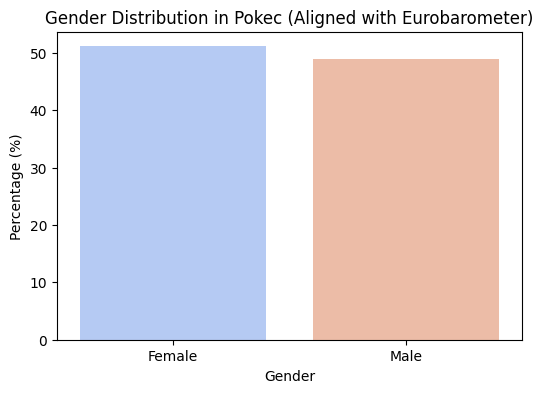

In [23]:
# count distribution of gender
gender_distribution = profiles_cleaned["gender"].value_counts(normalize=True) * 100
print(gender_distribution)

# plot gender distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=gender_distribution.index, y=gender_distribution.values, palette="coolwarm")
plt.xlabel("Gender")
plt.ylabel("Percentage (%)")
plt.title("Gender Distribution in Pokec (Aligned with Eurobarometer)")
plt.show()

In [24]:
from sentence_transformers import SentenceTransformer

# load SBERT model for encoding text
model = SentenceTransformer('all-MiniLM-L6-v2')

In [25]:
import torch

# function to encode text responses in batches
def encode_text_column_batched(column, batch_size=10000):
    encoded_texts = []
    for i in range(0, len(column), batch_size):
        batch = column.iloc[i : i + batch_size].astype(str).tolist()
        batch_embeddings = model.encode(batch, convert_to_tensor=True)
        encoded_texts.append(batch_embeddings)
        print(f"Processed {i + len(batch)} / {len(column)} rows")  # track progress
    return torch.cat(encoded_texts, dim=0)

# encode in batches
education_embeddings = encode_text_column_batched(profiles_cleaned["completed_level_of_education"])
children_embeddings = encode_text_column_batched(profiles_cleaned["children"])
marital_status_embeddings = encode_text_column_batched(profiles_cleaned["marital_status"])

Processed 10000 / 230305 rows
Processed 20000 / 230305 rows
Processed 30000 / 230305 rows
Processed 40000 / 230305 rows
Processed 50000 / 230305 rows
Processed 60000 / 230305 rows
Processed 70000 / 230305 rows
Processed 80000 / 230305 rows
Processed 90000 / 230305 rows
Processed 100000 / 230305 rows
Processed 110000 / 230305 rows
Processed 120000 / 230305 rows
Processed 130000 / 230305 rows
Processed 140000 / 230305 rows
Processed 150000 / 230305 rows
Processed 160000 / 230305 rows
Processed 170000 / 230305 rows
Processed 180000 / 230305 rows
Processed 190000 / 230305 rows
Processed 200000 / 230305 rows
Processed 210000 / 230305 rows
Processed 220000 / 230305 rows
Processed 230000 / 230305 rows
Processed 230305 / 230305 rows
Processed 10000 / 230305 rows
Processed 20000 / 230305 rows
Processed 30000 / 230305 rows
Processed 40000 / 230305 rows
Processed 50000 / 230305 rows
Processed 60000 / 230305 rows
Processed 70000 / 230305 rows
Processed 80000 / 230305 rows
Processed 90000 / 230305 

In [26]:
# convert embeddings from tensor to numpy (move to cpu first if using MPS/GPU)
education_embeddings_np = education_embeddings.cpu().numpy()
children_embeddings_np = children_embeddings.cpu().numpy()
marital_status_embeddings_np = marital_status_embeddings.cpu().numpy()

# fit KMeans on converted NumPy arrays
education_clusters_refined = KMeans(n_clusters=5, random_state=42).fit_predict(education_embeddings_np)
children_clusters_refined = KMeans(n_clusters=3, random_state=42).fit_predict(children_embeddings_np)  # updated
marital_clusters_refined = KMeans(n_clusters=4, random_state=42).fit_predict(marital_status_embeddings_np)

/Users/lijiayu/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/lijiayu/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/lijiayu/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [27]:
profiles_cleaned["education_cluster"] = education_clusters_refined
profiles_cleaned["children_cluster"] = children_clusters_refined
profiles_cleaned["marital_cluster"] = marital_clusters_refined

In [28]:
# check education clusters
for cluster in profiles_cleaned["education_cluster"].unique():
    print(f"Education Cluster {cluster}:")
    print(profiles_cleaned[profiles_cleaned["education_cluster"] == cluster]["completed_level_of_education"].sample(10, random_state=42).tolist())
    print("\n")

Education Cluster 0:
['zakladne, stredoskolske a na vysokom sa pracuje', 'vysokoskolske, ale akosika sa na to necitim!!', 'stredoskolske, uz nestudujem,len s nostalgiou spominam:-)))a placem kazdy vecer do vankusa:-)))))', 'neustale sa ucim', 'zakladne, zakladna skola 4 ever..., stredoskolske, akurat ze vysoka budova:d', 'maturita', 'napr.: zakladne, ucnovske, vysokoskolske, stredoskolske', 'bakalarske', 'd', 'superior']


Education Cluster 2:
['zakladne', 'zakladne', 'zakladne', 'zakladne', 'zakladne', 'zakladne', 'zakladne', 'zakladne, stredoskolske', 'zakladne', 'zakladne, aj to len tak tak']


Education Cluster 1:
['stredoskolske', 'stredoskolske', 'stredoskolske', 'stredoskolske', 'stredoskolske', 'stredoskolske', 'stredoskolske', 'stredoskolske', 'stredoskolske', 'stredoskolske']


Education Cluster 3:
['ucnovske', 'ucnovske', 'ucnovske', 'ucnovske', 'ucnovske', 'ucnovske', 'ucnovske', 'ucnovske', 'ucnovske', 'ucnovske']


Education Cluster 4:
['zakladne, stredoskolske, vysokosko

In [29]:
# check children clusters
for cluster in profiles_cleaned["children_cluster"].unique():
    print(f"Children Cluster {cluster}:")
    print(profiles_cleaned[profiles_cleaned["children_cluster"] == cluster]["children"].sample(10, random_state=42).tolist())
    print("\n")


Children Cluster 1:
['11', 'tiez ine info nepodavam..', 'mam rada deticky preto som chcela byt pediatrickou ale nevydalo tak som chemicka:-)', 'nerozumiem....dalsia otazka', 'su fajn len treba vediet ako s nimi.', 'work in progress', 'eeee deti to nie', 'nemaaam ale chcem mat najviac tri...', 'naco deti???', '2']


Children Cluster 0:
['chcem mat deti', 'v buducnosti by som chcela mat', 'v buducnosti chcem mat', 'v buducnosti chcem mat', 'nemam chcem mat dve :d', 'v buducnosti chcem mat deti', 'v buducnosti chcem mat', 'v buducnosti chcem mat', 'v buducnosti chcem mat', 'uz by som nechcel(a) mat']


Children Cluster 2:
['nemam', 'nemam', 'nemam', 'nemam', 'nemam', 'nemam', 'mam 9', 'nemam', 'nemam', 'nemam']




In [30]:
# check marital status clusters
for cluster in profiles_cleaned["marital_cluster"].unique():
    print(f"Marital Cluster {cluster}:")
    print(profiles_cleaned[profiles_cleaned["marital_cluster"] == cluster]["marital_status"].sample(10, random_state=42).tolist())
    print("\n")

Marital Cluster 0:
['slobodny(a)', 'slobodny', 'slobodna', 'slobodny(a)', 'slobodny(a)', 'slobodny(a)', 'slobodny(a)', 'slobodny(a)', 'slobodny(a)', 'slobodna']


Marital Cluster 3:
['mam vztah', 'mam vazny vztah', 'volna :)', 'free (s)', 'zenaty nacisto', 'x', 'mam vazny vztah, trva to 6 rokov a neplanujem to ukoncit', 'vydata...zatial stastne....', 'nezadana.', 'slobodny(a), kamoska vravi, ze kym nema prsten na prste, tak je slobodna..ja som tiez slobodna, ale v mojom zivote je niekto, koho velmi lubim..']


Marital Cluster 1:
['zenaty (vydata)', 'vydata', 'zenaty (vydata)', 'zenaty (vydata)', 'zenaty (vydata)', 'zenaty', 'zenaty (vydata)', 'zenaty (vydata)', 'zenaty (vydata)', 'zenaty (vydata)']


Marital Cluster 2:
['rozvedeny', 'rozvedeny(a)', 'rozvedeny(a)', 'rozvedeny(a)', 'rozvedeny(a)', 'rozvedeny(a)', 'rozvedeny(a)', 'rozvedena', 'rozvedeny(a)', 'rozvedeny(a)']




In [31]:
# preserve original text before applying clustering-based mapping
profiles_cleaned["marital_status_original"] = profiles_cleaned["marital_status"]

# assign categories based on clustering first
education_cluster_mapping = {
    0: "Middle",  # Mostly 'stredoskolske'
    1: "Low",     # Mostly 'zakladne'
    2: "Other Unclear Responses",  # Mixed unclear responses
    3: "Vocational",  # Mostly 'ucnovske'
    4: "High"     # Mostly 'vysokoskolske'
}

children_cluster_mapping = {
    0: "Yes",  # Mostly mentions of having children
    1: "No",   # Mostly mentions of future plans or no children
    2: "Other Unclear Responses"  # Mixed responses
}

marital_cluster_mapping = {
    0: "Single",  
    1: "Married",  
    2: "Divorced or Widowed",  
    3: "Other Unclear Responses"  # Contains mixed responses, relationships, unclear responses
}

# apply cluster-based categorization
profiles_cleaned["education_level"] = profiles_cleaned["education_cluster"].map(education_cluster_mapping)
profiles_cleaned["children_status"] = profiles_cleaned["children_cluster"].map(children_cluster_mapping)
profiles_cleaned["marital_status"] = profiles_cleaned["marital_cluster"].map(marital_cluster_mapping)

In [32]:
# Fix misclassified High Education cases
profiles_cleaned.loc[
    profiles_cleaned["completed_level_of_education"].str.contains(
        r"\bvs\b|terciaria|univerzita|bakalarske|doktorandske|mgr|ing|phd", 
        case=False, na=False
    ) & (profiles_cleaned["education_level"] != "Vocational"),  # Ensure no misclassification
    "education_level"
] = "High"

# Fix misclassified Low Education cases
profiles_cleaned.loc[
    profiles_cleaned["completed_level_of_education"].str.contains(
        r"\bzakladne\b|zakladka|zakladnu školu", case=False, na=False
    ),
    "education_level"
] = "Low"

# Fix misclassified Vocational cases
profiles_cleaned.loc[
    profiles_cleaned["completed_level_of_education"].str.contains(
        r"ucnovske|prakticka|odborna|remeslo|stredna odborna", case=False, na=False
    ),
    "education_level"
] = "Vocational"

# Fix misclassified children cases
profiles_cleaned.loc[
    profiles_cleaned["children"].str.contains(
        r"\bnemam\b|nechcem|neplanujem deti", case=False, na=False
    ),
    "children_status"
] = "No"

profiles_cleaned.loc[
    profiles_cleaned["children"].str.contains(
        r"\bmam\b.*\bdeti\b|\bmam\b.*\bsyna\b|\bmam\b.*\bdceru\b|\bmam\b.*\bdieta\b|\bmam\b.*\bchlapca\b",
        case=False, na=False
    ),
    "children_status"
] = "Yes"

# Fix misclassified marital status cases
profiles_cleaned.loc[
    profiles_cleaned["marital_status_original"].str.contains(
        r"\bvdovec\b|\bvdova\b", case=False, na=False
    ),
    "marital_status"
] = "Divorced or Widowed"

profiles_cleaned.loc[
    profiles_cleaned["marital_status_original"].str.contains(
        r"\bzasnubeny\b|\bsnubena\b", case=False, na=False
    ),
    "marital_status"
] = "Cohabiting"

In [33]:
def refine_education(text, current_category):
    """Refines education category after clustering, ensuring better classification of unclear responses."""
    text = text.lower().strip()

    # If already assigned a category, return it
    if current_category != "Other Unclear Responses":
        return current_category

    # High Education (University Level)
    if any(word in text for word in [
        "vysokoskolske", "univerzita", "bakalarske", "doktorandske", "mgr", "ing", "phd"
    ]):
        return "High"

    # Middle Education (High School Level)
    elif any(word in text for word in [
        "stredoskolske", "maturita", "gymnazium", "akademia"
    ]):
        return "Middle"

    # Vocational Education
    elif any(word in text for word in [
        "ucnovske", "prakticka", "odborna", "remeslo", "stredna odborna", "stredná odborná škola"
    ]):
        return "Vocational"

    # Low Education (Elementary Level)
    elif any(word in text for word in [
        "zakladne", "zakladka", "zs", "ms"
    ]):
        return "Low"

    # No Education
    elif any(word in text for word in [
        "ziadne vzdelanie", "bez skoly", "bez vzdelania", "ziadne skoly", "nemam vzdelanie"
    ]):
        return "No education"

    # Handle "Studying" Cases Using Context
    elif any(word in text for word in [
        "studujem", "momentálne studujem", "este studujem"
    ]):
        if "vs" in text or "univerzita" in text:  # Studying at university level
            return "High"
        elif "maturitu dorobim" in text or "stredna" in text:  # Studying in high school
            return "Middle"
        elif "zakladna" in text:  # Studying at elementary level
            return "Low"
        elif "ucnovske" in text or "stredná odborná" in text:  # Studying vocational education
            return "Vocational"

    # If none of the above applies, assign to "Other Unclear Responses"
    return "Other Unclear Responses"

In [34]:
def refine_marital(text, current_category, children_status):
    """refines marital status after clustering, ensuring better handling of cohabiting, single parents, and unclear responses."""
    text = text.lower().strip()

    if current_category == "other unclear responses":
        if any(word in text for word in ["zenaty", "vydata", "manzel", "manzelka", "moj manzel", "mam zenu", "stastne zenaty"]):
            return "married"
        elif any(word in text for word in ["vztah", "partner", "byvam s", "zadana", "spolu zijeme", "mam vazny vztah", 
                                           "zasnubeny", "snubenie", "frajer", "frajerka", "priatel", "snubenica", "drahý", "drahá"]):
            return "cohabiting"
        elif any(word in text for word in ["rozvedeny", "rozvedena", "ex-manzel", "ex-manželka", "expartner", "vdovec", "vdova"]):
            return "divorced or widowed"
        elif any(word in text for word in ["slobodny", "single", "nezadany", "nemam partnera"]):
            return "single"

    # reassign single parents to divorced or widowed
    if current_category == "single" and children_status == "yes":
        return "divorced or widowed"

    return current_category


In [35]:
def refine_children(text, current_category):
    """Refines children status after clustering."""
    text = text.lower().strip()

    # If already assigned a category, return it
    if current_category != "Other Unclear Responses":
        return current_category

    # Clearly has children (explicit mentions of children, numbers, or relationships)
    if any(char.isdigit() for char in text) or any(word in text for word in [
        "mam deti", "mam dieta", "mam syna", "mam dceru", "mám jedno dieta",
        "mam 2 deti", "mam troch synov", "som matka", "moje dieta"
    ]):
        return "Yes"

    # No children, future plans, or uncertainty
    elif any(word in text for word in [
        "nemam", "ziadne", "nechcem", "v buducnosti", "zatial", 
        "mozno", "este neviem", "planujem", "asi ano", "uvidim"
    ]):
        return "No"

    # Humor, jokes, or emojis that do not indicate having children
    elif any(word in text for word in [":)", "zlate", "haha", "lol", "neznasam", "co deti?"]):
        return "No"

    # Default to "Other Unclear Responses" if nothing matches
    return "Other Unclear Responses"

In [36]:
# refine only unclear responses or incorrect mappings
profiles_cleaned["education_level"] = profiles_cleaned.apply(
    lambda row: refine_education(row["completed_level_of_education"], row["education_level"]), axis=1
)

profiles_cleaned["children_status"] = profiles_cleaned.apply(
    lambda row: refine_children(row["children"], row["children_status"]), axis=1
)

profiles_cleaned["marital_status"] = profiles_cleaned.apply(
    lambda row: refine_marital(row["marital_status"], row["marital_status"], row["children_status"]), axis=1
)


In [37]:
# compare final category distributions
print(profiles_cleaned["education_level"].value_counts())
print(profiles_cleaned["children_status"].value_counts())
print(profiles_cleaned["marital_status"].value_counts())

Low                        149479
Middle                      37391
High                        27067
Vocational                  15470
Other Unclear Responses       898
Name: education_level, dtype: int64
No                         176190
Yes                         40195
Other Unclear Responses     13920
Name: children_status, dtype: int64
Single                     106245
Other Unclear Responses     69564
Married                     26291
Divorced or Widowed         23477
Cohabiting                   4728
Name: marital_status, dtype: int64


In [38]:
# filter out rows where any column has "Other Unclear Responses"
profiles_cleaned = profiles_cleaned[
    (profiles_cleaned["education_level"] != "Other Unclear Responses") &
    (profiles_cleaned["children_status"] != "Other Unclear Responses") &
    (profiles_cleaned["marital_status"] != "Other Unclear Responses")
]

# check new dataset size after removing unclear responses
print(f"Dataset size after removing unclear responses: {profiles_cleaned.shape[0]}")

Dataset size after removing unclear responses: 148919


In [59]:
# check final distributions after removing unclear responses
print("Final Education Level Distribution:")
print(profiles_cleaned["education_level"].value_counts(normalize=True) * 100)

print("\nFinal Children Status Distribution:")
print(profiles_cleaned["children_status"].value_counts(normalize=True) * 100)

print("\nFinal Marital Status Distribution:")
print(profiles_cleaned["marital_status"].value_counts(normalize=True) * 100)


Final Education Level Distribution:
Low           69.095951
High          12.817035
Middle        10.963007
Vocational     7.124007
Name: education_level, dtype: float64

Final Children Status Distribution:
No     79.210846
Yes    20.789154
Name: children_status, dtype: float64

Final Marital Status Distribution:
Single                 69.040216
Married                14.869829
Divorced or Widowed    13.204494
Cohabiting              2.885461
Name: marital_status, dtype: float64


In [62]:
# filter profiles_benchmark to contain only matching user_ids from profiles_cleaned
profiles_benchmark = profiles[profiles["user_id"].isin(profiles_cleaned["user_id"])].copy().dropna()


# keep only raw textual data for alternative classification
profiles_benchmark = profiles_benchmark[[
    "user_id", "completed_level_of_education", "children", "marital_status"
]]

In [63]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

def extract_lda_topics(feature_column, num_topics):
    """Extracts LDA topics, prints top words, and returns topic-word mappings."""
    
    # Better Preprocessing: Remove stopwords, normalize text
    vectorizer = CountVectorizer(max_features=5000, stop_words="english")
    X = vectorizer.fit_transform(profiles_benchmark[feature_column].astype(str))

    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(X)

    feature_names = vectorizer.get_feature_names_out()
    topic_word_mapping = {}

    for topic_idx, topic in enumerate(lda.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
        topic_word_mapping[topic_idx] = top_words
        print(f"Topic {topic_idx}: {', '.join(top_words)}")

    return topic_word_mapping

print("Education Topics:")
education_topics = extract_lda_topics("completed_level_of_education", 5)

print("\nChildren Topics:")
children_topics = extract_lda_topics("children", 3)

print("\nMarital Topics:")
marital_topics = extract_lda_topics("marital_status", 4)


Education Topics:
Topic 0: zakladne, ucnovske, zatial, maturou, skolkarske, ss, materske, stolar, zumpar, sluzieb
Topic 1: vysokoskolske, mam, ing, sos, sps, quot, magisterske, ake, podnikanie, ano
Topic 2: stredoskolske, maturitou, sou, zatial, maturita, obchodne, elektrotechnicke, skvolka, ekonomicke, sous
Topic 3: som, na, studujem, este, sa, ale, uz, skolka, je, strednej
Topic 4: bakalarske, na, sa, aj, skola, pracuje, stredne, ale, vs, uz

Children Topics:
Topic 0: mat, chcem, buducnosti, mam, deti, este, neviem, nechcem, syna, rada
Topic 1: zatial, ale, su, ziadne, na, sa, je, deti, nie, jedno
Topic 2: nemam, som, dve, uz, este, chcel, aspon, ale, neviem, mozno

Marital Topics:
Topic 0: slobodny, nezadany, free, slobodni, bezdetny, aspon, bohu, chvala, bohuzial, forever
Topic 1: vydata, zenaty, slobodna, rozvedena, zatial, single, stastna, od, nezadana, slobodne
Topic 2: vdovec, vdova, zasnubeny, stastne, ale, som, uz, zadana, sa, rozvedena
Topic 3: rozvedeny, mam, vztah, vazny, 

In [67]:
def assign_lda_topics(feature_column, num_topics, column_name):
    """Assigns LDA topic clusters to a feature column and stores them in profiles_benchmark."""
    vectorizer = CountVectorizer(max_features=5000, stop_words="english")
    X = vectorizer.fit_transform(profiles_benchmark[feature_column].astype(str))

    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    topic_distributions = lda.fit_transform(X)  # Get topic probabilities for each row
    
    # Assign the most probable topic to each row
    profiles_benchmark[column_name] = topic_distributions.argmax(axis=1)

# Assign numeric topics before mapping
assign_lda_topics("completed_level_of_education", 5, "education_level_lda")
assign_lda_topics("children", 3, "children_status_lda")
assign_lda_topics("marital_status", 4, "marital_status_lda")

In [68]:
education_lda_mapping = {
    0: "Low",          # "zakladne", "ucnovske", "materske", "skolkarske" → Basic/elementary
    1: "Vocational",   # "elektrotechnika", "praca", "sous" → Vocational education
    2: "Middle",       # "stredoskolske", "maturita", "gymnazium" → High school
    3: "High",         # "vysokoskolske", "bakalarske", "ing" → University
    4: "Low"   # "studujem", "som", "este" → Studying, needs context
}

children_lda_mapping = {
    0: "No",  # "mam" (I have), "dcerku" (daughter), "synceka" (son) → Clearly has children
    1: "No",   # "nemam" (I don’t have), "neviem" (I don’t know yet), "mozno" (maybe in future)
    2: "Yes"   # "mam", "deti" (children), "dve" (two) → Clearly has children
}

marital_lda_mapping = {
    0: "Single",                # "slobodny", "nezadany" (single, not in a relationship)
    1: "Married",         # Mix of single and married words, needs manual review
    2: "Divorced or Widowed",   # "rozvedena", "vdovec", but REMOVE "zasnubeny"
    3: "Cohabiting"             # "mam vztah" (I have a relationship), "vazny" (serious relationship)
}


# Apply mappings
profiles_benchmark["education_level_lda"] = profiles_benchmark["education_level_lda"].map(education_lda_mapping)
profiles_benchmark["children_status_lda"] = profiles_benchmark["children_status_lda"].map(children_lda_mapping)
profiles_benchmark["marital_status_lda"] = profiles_benchmark["marital_status_lda"].map(marital_lda_mapping)

In [69]:
print("Benchmark Education Level Distribution:")
print(profiles_benchmark["education_level_lda"].value_counts(normalize=True) * 100, "\n")

print("Benchmark Children Status Distribution:")
print(profiles_benchmark["children_status_lda"].value_counts(normalize=True) * 100, "\n")

print("Benchmark Marital Status Distribution:")
print(profiles_benchmark["marital_status_lda"].value_counts(normalize=True) * 100, "\n")


Benchmark Education Level Distribution:
Middle        43.098597
Low           38.894298
Vocational    10.277399
High           7.729705
Name: education_level_lda, dtype: float64 

Benchmark Children Status Distribution:
No     71.540905
Yes    28.459095
Name: children_status_lda, dtype: float64 

Benchmark Marital Status Distribution:
Single                 65.072959
Married                18.057467
Cohabiting              9.306401
Divorced or Widowed     7.563172
Name: marital_status_lda, dtype: float64 



In [70]:
import numpy as np
from scipy.stats import entropy  # KL Divergence

def align_distributions(lda_dist, cluster_dist):
    """Ensures both distributions have the same categories for KL Divergence."""
    all_categories = set(lda_dist.index).union(set(cluster_dist.index))
    
    # Reindex with all categories, filling missing ones with 0
    lda_dist = lda_dist.reindex(all_categories, fill_value=0)
    cluster_dist = cluster_dist.reindex(all_categories, fill_value=0)
    
    return lda_dist, cluster_dist

# Align distributions before computing KL Divergence
lda_education_dist, cluster_education_dist = align_distributions(
    profiles_benchmark["education_level_lda"].value_counts(normalize=True),
    profiles_cleaned["education_level"].value_counts(normalize=True)
)

lda_children_dist, cluster_children_dist = align_distributions(
    profiles_benchmark["children_status_lda"].value_counts(normalize=True),
    profiles_cleaned["children_status"].value_counts(normalize=True)
)

lda_marital_dist, cluster_marital_dist = align_distributions(
    profiles_benchmark["marital_status_lda"].value_counts(normalize=True),
    profiles_cleaned["marital_status"].value_counts(normalize=True)
)

# Compute KL Divergence
kl_div_education = entropy(lda_education_dist, cluster_education_dist)
kl_div_children = entropy(lda_children_dist, cluster_children_dist)
kl_div_marital = entropy(lda_marital_dist, cluster_marital_dist)

print(f"KL Divergence - Education: {kl_div_education:.4f}")
print(f"KL Divergence - Children: {kl_div_children:.4f}")
print(f"KL Divergence - Marital Status: {kl_div_marital:.4f}")


KL Divergence - Education: 0.3651
KL Divergence - Children: 0.0165
KL Divergence - Marital Status: 0.0634


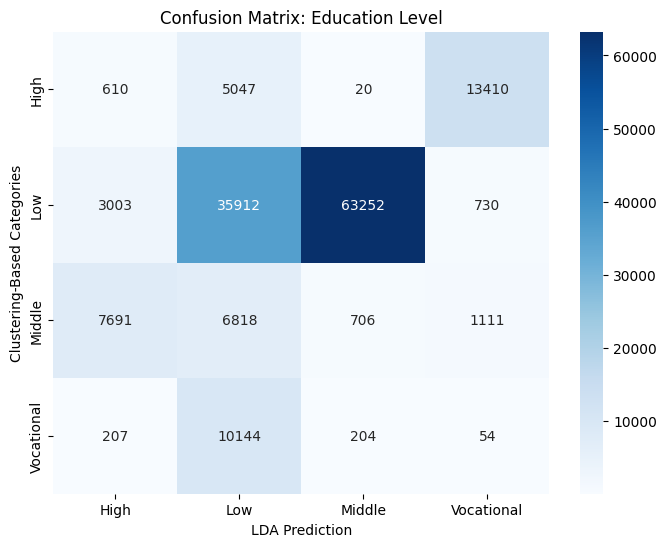

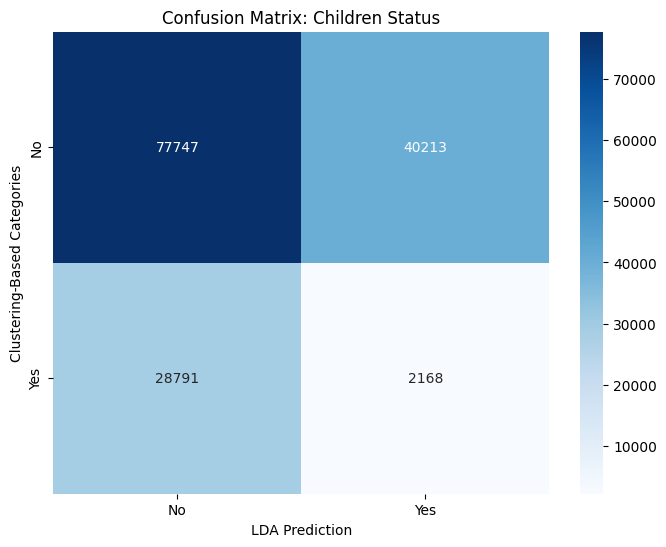

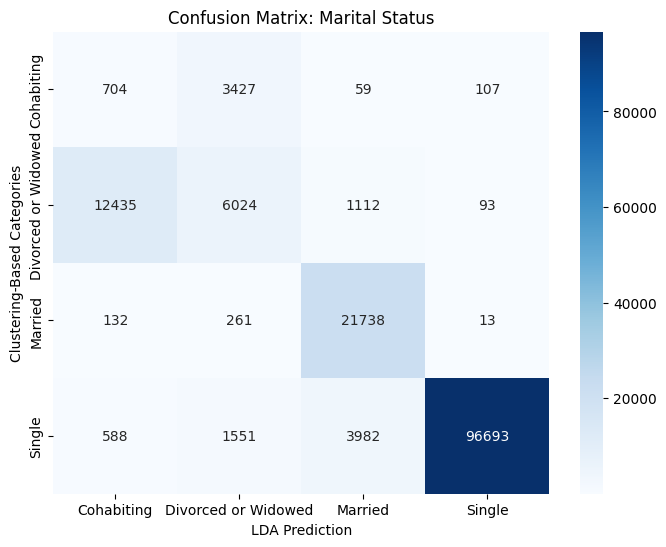

In [71]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel("LDA Prediction")
    plt.ylabel("Clustering-Based Categories")
    plt.title(f"Confusion Matrix: {title}")
    plt.show()

# Generate confusion matrices
plot_confusion_matrix(profiles_cleaned["education_level"], profiles_benchmark["education_level_lda"], "Education Level")
plot_confusion_matrix(profiles_cleaned["children_status"], profiles_benchmark["children_status_lda"], "Children Status")
plot_confusion_matrix(profiles_cleaned["marital_status"], profiles_benchmark["marital_status_lda"], "Marital Status")


In [72]:
from sklearn.metrics import cohen_kappa_score

# Compute Cohen's Kappa Score (Agreement beyond random chance)
kappa_education = cohen_kappa_score(profiles_benchmark["education_level_lda"], profiles_cleaned["education_level"])
kappa_children = cohen_kappa_score(profiles_benchmark["children_status_lda"], profiles_cleaned["children_status"])
kappa_marital = cohen_kappa_score(profiles_benchmark["marital_status_lda"], profiles_cleaned["marital_status"])

print(f"Cohen's Kappa Score - Education: {kappa_education:.4f}")
print(f"Cohen's Kappa Score - Children: {kappa_children:.4f}")
print(f"Cohen's Kappa Score - Marital Status: {kappa_marital:.4f}")

Cohen's Kappa Score - Education: -0.1243
Cohen's Kappa Score - Children: -0.2384
Cohen's Kappa Score - Marital Status: 0.6879


In [87]:
display(profiles_cleaned.columns)
print(profiles_cleaned.shape)

Index(['user_id', 'gender', 'completed_level_of_education', 'children',
       'marital_status', 'age_group', 'education_cluster', 'children_cluster',
       'marital_cluster', 'marital_status_original', 'education_level',
       'children_status'],
      dtype='object')

(148919, 12)


In [92]:
# filter edges to retain only users who are present in profiles_cleaned
edges_filtered = edges[
    (edges["source"].isin(profiles_cleaned["user_id"])) & 
    (edges["target"].isin(profiles_cleaned["user_id"]))
].copy()

print(f"original edges count: {edges.shape[0]}")
print(f"filtered edges count (only users in profiles_cleaned): {edges_filtered.shape[0]}")

original edges count: 30622564
filtered edges count (only users in profiles_cleaned): 425217


In [93]:
# merge source user attributes
edges_merged = edges_filtered.merge(
    profiles_cleaned, left_on="source", right_on="user_id", how="left"
)

# rename columns to differentiate source attributes
edges_merged.rename(columns={
    "gender": "gender_source",
    "age_group": "age_group_source",
    "education_level": "education_level_source",
    "children_status": "children_status_source",
    "marital_status": "marital_status_source"
}, inplace=True)

# merge target user attributes
edges_merged = edges_merged.merge(
    profiles_cleaned, left_on="target", right_on="user_id", how="left"
)

# rename columns to differentiate target attributes
edges_merged.rename(columns={
    "gender": "gender_target",
    "age_group": "age_group_target",
    "education_level": "education_level_target",
    "children_status": "children_status_target",
    "marital_status": "marital_status_target"
}, inplace=True)

# drop duplicate user_id columns
edges_merged.drop(columns=["user_id_x", "user_id_y"], inplace=True)

# check for missing values
missing_values = edges_merged.isna().sum()
print("missing values in edges_merged:")
print(missing_values[missing_values > 0])

missing values in edges_merged:
Series([], dtype: int64)


In [94]:
# find users in profiles_cleaned who do not appear in the filtered edges dataset
isolated_users = set(profiles_cleaned["user_id"]) - set(edges_merged["source"]).union(set(edges_merged["target"]))
print(f"number of isolated users (no edges): {len(isolated_users)}")

number of isolated users (no edges): 32632


In [95]:
# create a dataframe for isolated users (self-loops)
isolated_users_df = profiles_cleaned[profiles_cleaned["user_id"].isin(isolated_users)].copy()

# assign self-loop edges for isolated users
isolated_users_df["source"] = isolated_users_df["user_id"]
isolated_users_df["target"] = isolated_users_df["user_id"]

# rename columns to match merged dataset structure
for col in ["gender", "age_group", "education_level", "children_status", "marital_status"]:
    isolated_users_df[f"{col}_source"] = isolated_users_df[col]
    isolated_users_df[f"{col}_target"] = isolated_users_df[col]

# retain only relevant columns
isolated_users_df = isolated_users_df[["source", "target"] + 
                                      [f"{col}_source" for col in ["gender", "age_group", "education_level", "children_status", "marital_status"]] + 
                                      [f"{col}_target" for col in ["gender", "age_group", "education_level", "children_status", "marital_status"]]]

display(isolated_users_df)

,source,target,gender_source,age_group_source,education_level_source,children_status_source,marital_status_source,gender_target,age_group_target,education_level_target,children_status_target,marital_status_target
226,282,282,Male,19-25,Low,No,Single,Male,19-25,Low,No,Single
1097,1172,1172,Male,19-25,High,No,Single,Male,19-25,High,No,Single
1195,1263,1263,Male,19-25,Low,No,Single,Male,19-25,Low,No,Single
1541,1303,1303,Male,19-25,Low,No,Single,Male,19-25,Low,No,Single
2109,2191,2191,Female,45-64,Low,Yes,Married,Female,45-64,Low,Yes,Married
...,...,...,...,...,...,...,...,...,...,...,...,...
1632698,1632699,1632699,Male,45-64,High,No,Divorced or Widowed,Male,45-64,High,No,Divorced or Widowed
1632729,1632730,1632730,Female,45-64,Low,No,Married,Female,45-64,Low,No,Married
1632757,1632758,1632758,Female,45-64,Low,No,Divorced or Widowed,Female,45-64,Low,No,Divorced or Widowed
1632766,1632767,1632767,Female,45-64,Low,No,Single,Female,45-64,Low,No,Single


In [96]:
# concatenate edges dataset with isolated users
final_pokec_dataset = pd.concat([edges_merged, isolated_users_df], ignore_index=True)

# check final dataset size
print(f"final dataset size: {final_pokec_dataset.shape}")
print(f"total unique users in network: {len(set(final_pokec_dataset['source']).union(set(final_pokec_dataset['target'])))}")

final dataset size: (457849, 24)
total unique users in network: 148919


In [97]:
# Export DataFrame to CSV
final_pokec_dataset.to_csv("final_pokec_dataset.csv", index=False)

In [99]:
# Define the columns of interest
columns_of_interest = ['gender', 'education_level', 'children_status', 'marital_status', 'age_group']

# Get unique values for each specified column
unique_values = {col: profiles_cleaned[col].unique() for col in columns_of_interest}

# Display unique values
for col, values in unique_values.items():
    print(f"Column: {col}")
    print(values, "\n")


Column: gender
['Male' 'Female'] 

Column: education_level
['Middle' 'Low' 'High' 'Vocational'] 

Column: children_status
['No' 'Yes'] 

Column: marital_status
['Single' 'Married' 'Divorced or Widowed' 'Cohabiting'] 

Column: age_group
['19-25', '15-18', '26-44', '45-64', '65+']
Categories (5, object): ['15-18' < '19-25' < '26-44' < '45-64' < '65+'] 

